In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from models import CNNClassifier
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [20]:
nconf = 31
ndata = 200
L = 64
T_cr = 2.269 # critical temp for 2d ising
t_start = 2.1

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Ising")
print(prm_list)
print(f"データ数:{nconf*ndata}")

[[2.1, '../dataset/2d_Ising/L64/L64T0_'], [2.11, '../dataset/2d_Ising/L64/L64T1_'], [2.12, '../dataset/2d_Ising/L64/L64T2_'], [2.13, '../dataset/2d_Ising/L64/L64T3_'], [2.14, '../dataset/2d_Ising/L64/L64T4_'], [2.15, '../dataset/2d_Ising/L64/L64T5_'], [2.16, '../dataset/2d_Ising/L64/L64T6_'], [2.17, '../dataset/2d_Ising/L64/L64T7_'], [2.18, '../dataset/2d_Ising/L64/L64T8_'], [2.19, '../dataset/2d_Ising/L64/L64T9_'], [2.2, '../dataset/2d_Ising/L64/L64T10_'], [2.21, '../dataset/2d_Ising/L64/L64T11_'], [2.22, '../dataset/2d_Ising/L64/L64T12_'], [2.23, '../dataset/2d_Ising/L64/L64T13_'], [2.24, '../dataset/2d_Ising/L64/L64T14_'], [2.25, '../dataset/2d_Ising/L64/L64T15_'], [2.26, '../dataset/2d_Ising/L64/L64T16_'], [2.27, '../dataset/2d_Ising/L64/L64T17_'], [2.28, '../dataset/2d_Ising/L64/L64T18_'], [2.29, '../dataset/2d_Ising/L64/L64T19_'], [2.3, '../dataset/2d_Ising/L64/L64T20_'], [2.31, '../dataset/2d_Ising/L64/L64T21_'], [2.32, '../dataset/2d_Ising/L64/L64T22_'], [2.33, '../dataset/2d_I

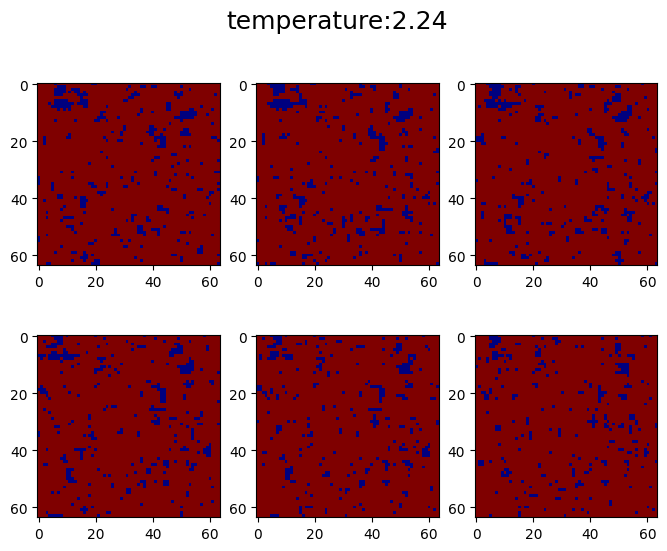

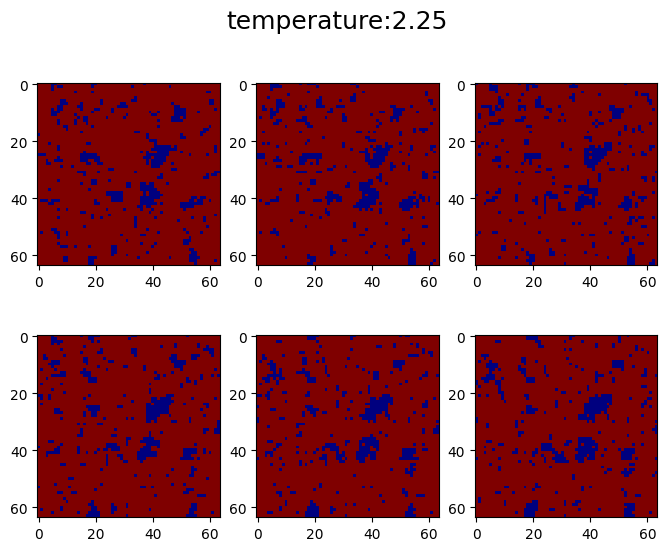

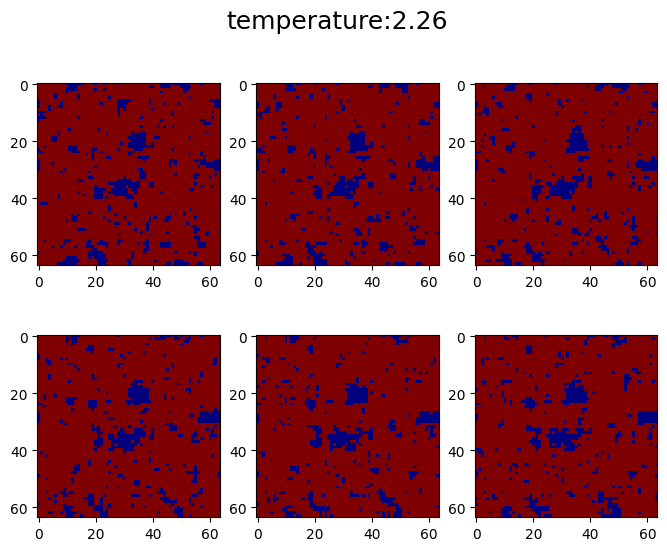

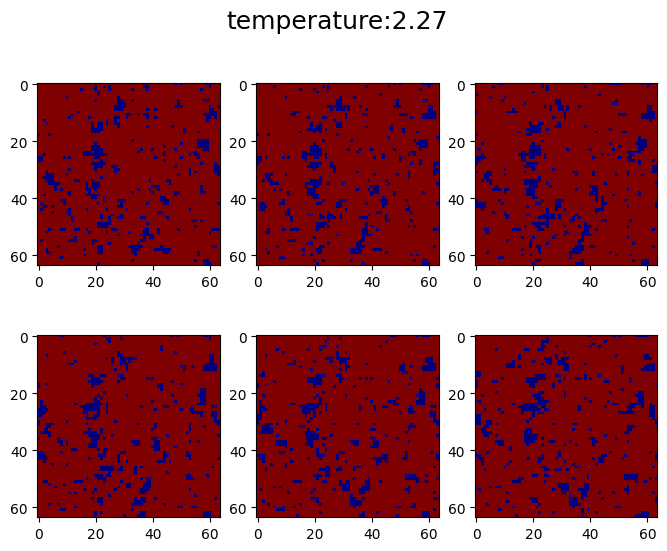

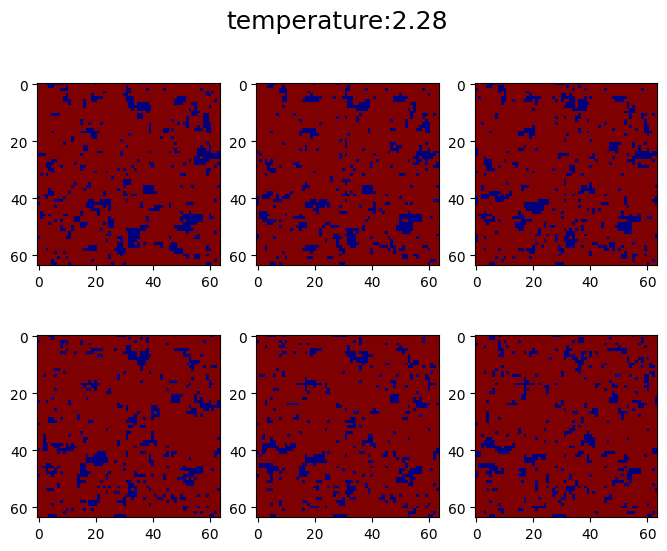

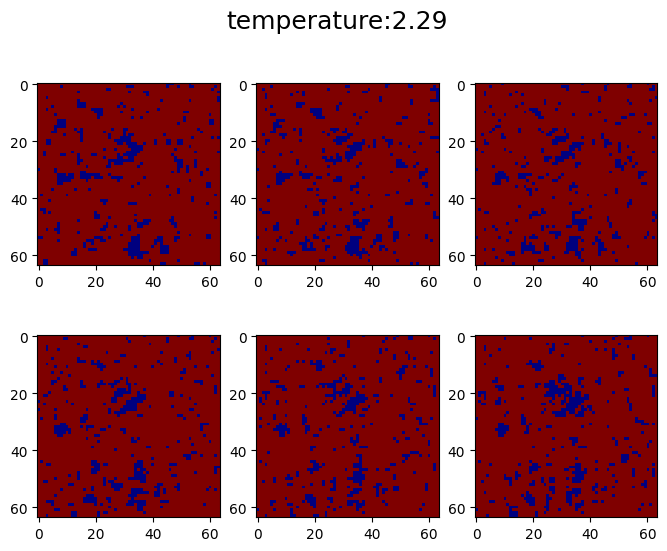

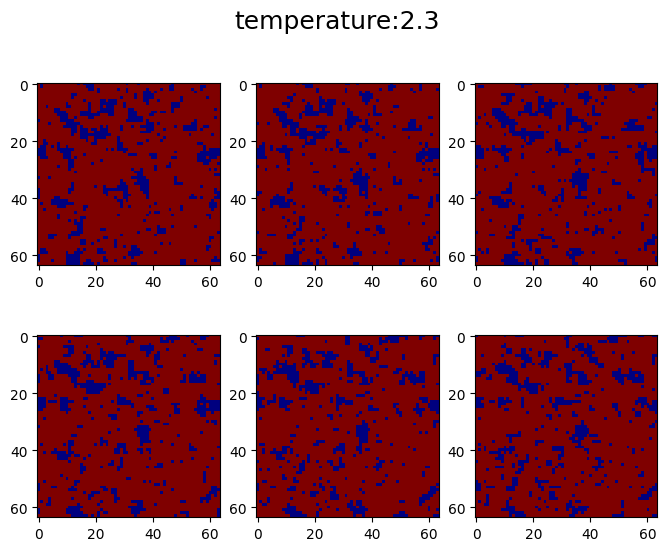

In [28]:
# 可視化
row = 2  # 行数
col = 3  # 列数

for num in range(14, 21):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
    fig.suptitle(f"temperature:{prm_list[num][0]}", fontsize=18, color='black')
    for iconf in range(6):
        _r = iconf//col
        _c = iconf % col
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        ax[_r,_c].imshow(sc, interpolation='nearest', vmin=0, vmax=1, cmap='jet')

In [11]:
# hold out
dataset, _ = create_train_data_CV(prm_list, ndata, T_cr, exclude_T=(2.23, 2.31), total_label=2)
print("dataset.shape = ", len(dataset))

dataset.shape =  5200


mps is available.
FOLD 1
--------------------------------
Epoch: 1, Validation loss: 0.0019618930868231335, Accuracy: 94.71153846153847%
Epoch: 6, Validation loss: 0.0013395976565684228, Accuracy: 97.21153846153847%


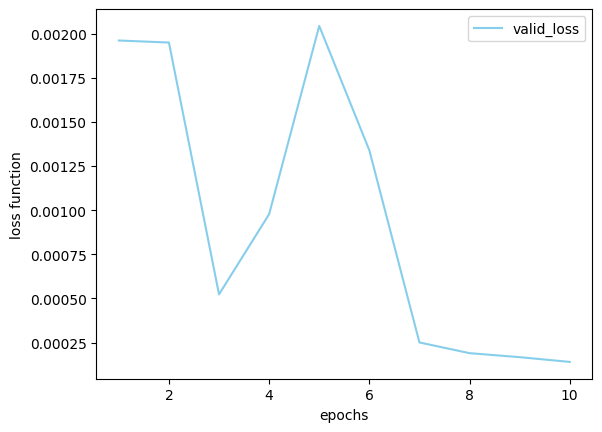

FOLD 2
--------------------------------
Epoch: 1, Validation loss: 0.003556101883833225, Accuracy: 93.46153846153847%
Epoch: 6, Validation loss: 0.0009194922463323634, Accuracy: 97.6923076923077%


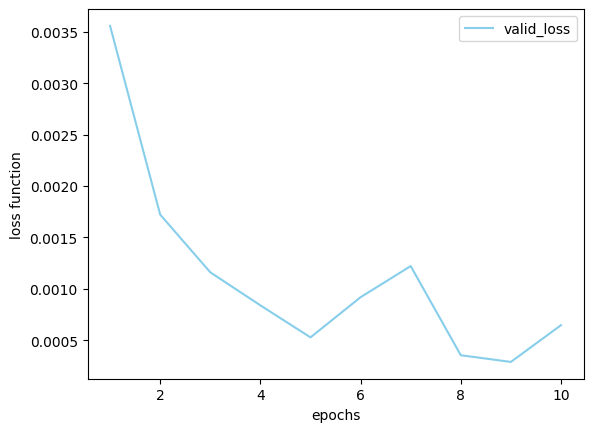

FOLD 3
--------------------------------
Epoch: 1, Validation loss: 0.002589218153689916, Accuracy: 93.17307692307692%
Epoch: 6, Validation loss: 0.0002459546177306038, Accuracy: 99.42307692307692%


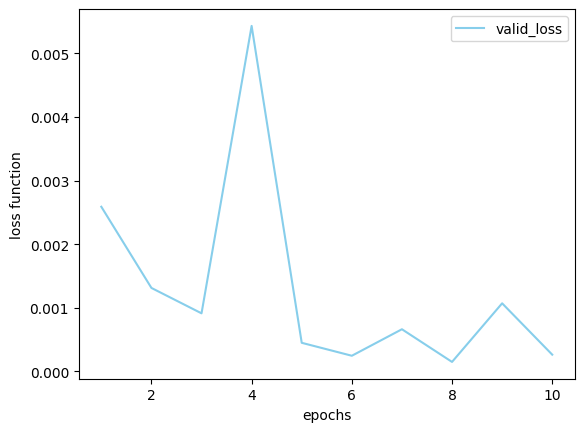

FOLD 4
--------------------------------
Epoch: 1, Validation loss: 0.002956071166464916, Accuracy: 92.6923076923077%
Epoch: 6, Validation loss: 0.0006425446485921454, Accuracy: 98.84615384615384%


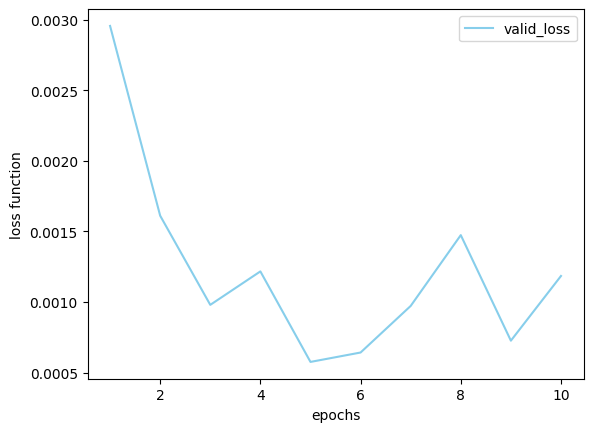

FOLD 5
--------------------------------
Epoch: 1, Validation loss: 0.0021183822518930986, Accuracy: 94.42307692307692%
Epoch: 6, Validation loss: 0.0002545929453984942, Accuracy: 99.42307692307692%


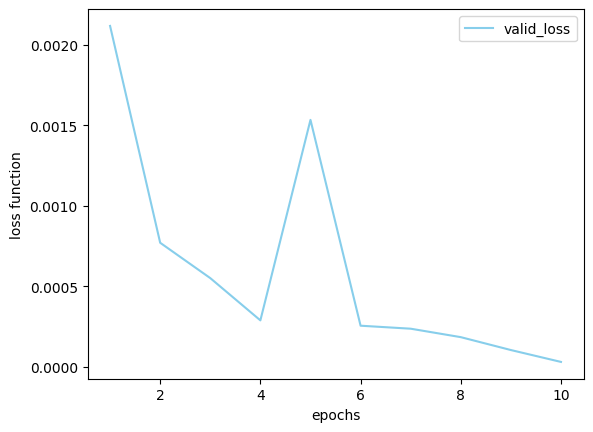

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
Done.


In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
target_size = 2
grad_clip = 0.1
norm_type = 2
epochs = 10
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)
    
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)
    
    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loss_list, vaild_loss_list, accuracy_list = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            valid_loss = 0
            correct = 0
            # answer, prediction = [], []
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                # prediction += list(pred.cpu().numpy())
                # answer += list(target.cpu().numpy())

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)
        
        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch % 3 == 0:
            print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
        # print("Classification Report:\n", classification_report(answer, prediction, digits=4))
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list, label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")
# torch.save(model, "2d_Ising_model_classifier.pth")

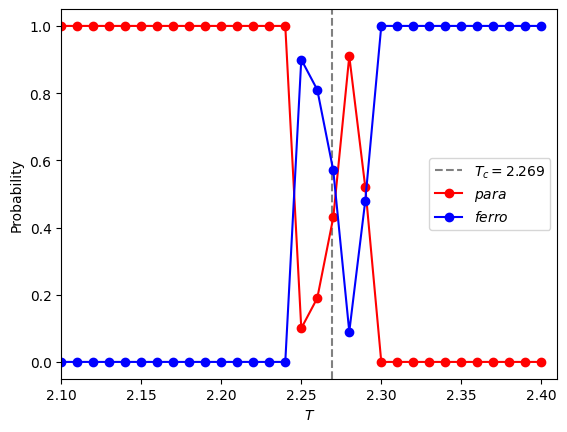

In [16]:
_, test_dataset = create_train_data_hold_out(prm_list, ndata, T_cr, exclude_T=(2.25, 2.29))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

xs, y1s, y2s, temps = [], [], [], []
prediction = []
sum_pred = 0
count = 0

model.eval()
for data, temp, target in test_loader:
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=False)
    prediction += list(pred.cpu().numpy())
    temps += list(temp.cpu().numpy())
# print(len(prediction), len(temps))

for i in range(len(test_dataset)):
    if i == 0:
        sum_pred += prediction[i]
        count += 1
        xs.append(temps[i])
    else:
        if temps[i] != temps[i-1]:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)

            sum_pred = 0
            count = 0
            sum_pred += prediction[i]
            count += 1
            xs.append(temps[i])
        elif i == len(test_dataset)-1:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)
        else:
            sum_pred += prediction[i]
            count += 1
# print(len(xs), len(y1s), len(y2s))

plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={}$".format(T_cr))
plt.xlim(t_start,t_end)
plt.plot(xs, y1s, label=r"$para$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$ferro$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()